In [14]:
from datetime import datetime, timezone, timedelta
import os
import pandas as pd # data processing
import bitmex
import math
from tqdm.notebook import trange, tqdm # progress bar
import time
import numpy as np
# import warnings  
# warnings.filterwarnings('ignore')


test_mode = False
key = '1rw8DDZoBd3xGXOmo48lFfQv' if test_mode else '73rdj2LQf63ANuFczBOlINsS'
secret = 'ODoX-aeLDeLSPWidAtqNpnN70eWDKLgfdpdIUL6_fifPZhEu' if test_mode else 'TmIdFVEN-Muni_TAKpA0zghts7EHv5ytq5vZfrPQXRxM01x7'
client = bitmex.bitmex(test=test_mode, api_key=key, api_secret=secret)
binsizes = {"1m": 1, "5m": 5, "1h": 60, "4h": 240, "1d": 1440}
batch_size = 750

def get_all_bitmex(symbol, kline_size, save = False, start_time = None):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "bitmex")
    oldest_point = start_time if start_time is not None else oldest_point
    print(newest_point, oldest_point)
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    rounds = math.ceil(available_data / batch_size)
    if rounds > 0:
        print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data in %d rounds.' % (delta_min, symbol, available_data, kline_size, rounds))
        for round_num in tqdm(range(rounds)):
            time.sleep(1)
            new_time = (oldest_point + timedelta(minutes = round_num * batch_size * binsizes[kline_size]))
            data = client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=batch_size, startTime = new_time).result()[0]
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
#     data_df.set_index('timestamp', inplace=True)
    if save and rounds > 0: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

def minutes_of_new_data(symbol, kline_size, data, source):
    print(kline_size)
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    elif source == "bitmex": old = client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    if source == "bitmex": new = client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new

In [9]:
btc_1h = get_all_bitmex('XBTUSD', '1h', save = False, start_time = datetime.strptime('01-01-2019 +0000', '%m-%d-%Y %z'))
btc_1h

1h
2020-04-03 22:00:00+00:00 2019-01-01 00:00:00+00:00



All caught up..!


,timestamp,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
0,2019-01-01 00:00:00+00:00,XBTUSD,3686.5,3695.5,3682.5,3693.0,10718,24965778,3689.7646,20,676636017934,6766.360179,24965778.0
1,2019-01-01 01:00:00+00:00,XBTUSD,3693.0,3705.0,3684.5,3694.0,9558,29678917,3695.0818,1102,803227026597,8032.270266,29678917.0
2,2019-01-01 02:00:00+00:00,XBTUSD,3694.0,3695.0,3675.5,3681.5,8563,18156574,3686.5000,2050,492520151894,4925.201519,18156574.0
3,2019-01-01 03:00:00+00:00,XBTUSD,3681.5,3683.5,3665.0,3678.5,9779,17395139,3676.6058,150,473140654578,4731.406546,17395139.0
4,2019-01-01 04:00:00+00:00,XBTUSD,3678.5,3687.0,3678.5,3685.0,6183,12509319,3683.9197,30000,339567556303,3395.675563,12509319.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,2020-04-03 18:00:00+00:00,XBTUSD,6750.5,6787.0,6672.5,6718.0,34872,75325671,6726.3066,3,1119914297754,11199.142978,75325671.0
511,2020-04-03 19:00:00+00:00,XBTUSD,6718.0,6756.5,6677.0,6744.5,27153,53799552,6718.1727,450,800857695966,8008.576960,53799552.0
512,2020-04-03 20:00:00+00:00,XBTUSD,6744.5,6789.0,6739.5,6771.5,24841,39353088,6764.5268,14000,581785651240,5817.856512,39353088.0
513,2020-04-03 21:00:00+00:00,XBTUSD,6771.5,6820.0,6680.0,6694.5,34966,81278667,6759.0402,4250,1202573656687,12025.736567,81278667.0


In [15]:
METHOD_NAIVE, METHOD_NAIVECONSEC, METHOD_NUMDIFF = 0, 1, 2
METHOD_NCUBED, METHOD_NSQUREDLOGN, METHOD_HOUGHPOINTS, METHOD_HOUGHLINES, METHOD_PROBHOUGH = 0, 1, 2, 3, 4
def calc_support_resistance(h, extmethod = METHOD_NUMDIFF, method=METHOD_NSQUREDLOGN,
                            window=125, errpct=0.005, hough_scale=0.01, hough_prob_iter=10,
                            sortError=False, accuracy=1):
    """ returns (list of minima indexes, list of maxima indexes, [support slope coefficient, intersect], [resistance slope coefficient, intersect], [[support point indexes], (slope, intercept, residual, slope error, intercept error, area on wrong side of trend line per time unit)]
    
    :param h: list/numpy ndarray/pandas Series of data as bool/int/float and if not a list also unsigned
                or 2-tuple (support, resistance) where support and resistance are 1-dimensional array-like or one or the other is None
                can calculate only support, only resistance, both for different data, or both for identical data
    :param extmethod: METHOD_NAIVE - any local minima or maxima only for a single interval (currently requires pandas)
                        METHOD_NAIVECONSEC - any local minima or maxima including those for consecutive constant intervals (currently requires pandas)
                        METHOD_NUMDIFF (default) - numerical differentiation determined local minima or maxima (requires findiff)
    :param method: METHOD_NCUBED - simple exhuastive 3 point search (slowest)
                    METHOD_NSQUREDLOGN (default) - 2 point sorted slope search (fast)
                    METHOD_HOUGHPOINTS - Hough line transform optimized for points
                    METHOD_HOUGHLINES - image-based Hough line transform (requires scikit-image)
                    METHOD_PROBHOUGH - image-based Probabilistic Hough line transform (requires scikit-image)
    :param window: window size when searching for trend lines prior to merging together
    :param errpct: maximum percentage slope standard error
    :param hough_scale: for all METHOD_*HOUGH*, the smallest unit increment for discretization e.g. cents/pennies 0.01
    :param hough_prob_iter: only for METHOD_PROBHOUGH, number of iterations to run
    :param sortError: sort by area under wrong side of curve, otherwise sort by slope standard error
    :param accuracy: accuracy if using METHOD_NUMDIFF for example 5-point stencil is accuracy=3
    :rtype: A :tuple:`(minima_idxs, p_min, min_trend, min_windows), (maxima_idxs, p_max, max_trend, max_windows)`
        - if h is a 2-tuple with one value as None, then a 2-tuple is not returned, but the appropriate tuple instead
        minima_idxs - sorted list of indexes to the local minima
        p_min - [slope, intercept] of average best fit line through all local minima points
        min_trend - sorted list containing (points, result) for local minima trend lines
        points - list of indexes to points in trend line
        result - (slope, intercept, SSR, slopeErr, interceptErr, areaAvg)
            slope - slope of best fit trend line
                intercept - y-intercept of best fit trend line
                SSR - sum of squares due to regression
                slopeErr - standard error of slope
                interceptErr - standard error of intercept
                areaAvg - Reimann sum area of difference between best fit trend line
                            and actual data points averaged per time unit
        minwindows - list of windows each containing mintrend for that window

        maxima_idxs - sorted list of indexes to the local maxima
        p_max - [slope, intercept] of average best fit line through all local maxima points
        max_trend - sorted list containing (points, result) for local maxima trend lines
                    see for mintrend above
        max_windows - list of windows each containing maxtrend for that window
        
    """
    if not type(window) is int:
        raise ValueError('window must be of type int')
    if not type(errpct) is float:
        raise ValueError('errpct must be of type float')
    if not type(hough_scale) is float:
        raise ValueError('house_scale must be of type float')
    if not type(hough_prob_iter) is int:
        raise ValueError('house_prob_iter must be of type int')
    if not type(sortError) is bool:
        raise ValueError('sortError must be True of False')
    #h = hist.Close.tolist()
    if type(h) is tuple and len(h) == 2 and (h[0] is None or check_num_alike(h[0])) and (h[1] is None or check_num_alike(h[1])) and (not h[0] is None or not h[1] is None):
        if not h[0] is None and not h[1] is None and len(h[0]) != len(h[1]): #not strict requirement, but contextually ideal
            raise ValueError('h does not have a equal length minima and maxima data')
        hmin, hmax, len_h = h[0], h[1], len(h[1 if h[0] is None else 0])
    elif check_num_alike(h): hmin, hmax, len_h = None, None, len(h)
    else: raise ValueError('h is not list, numpy ndarray or pandas Series of numeric values or a 2-tuple thereof')
    #https://stackoverflow.com/questions/8587047/support-resistance-algorithm-technical-analysis/8590007#8590007
    #print((minimaIdxs[-10:], maximaIdxs[-10:]))
    #https://en.wikipedia.org/wiki/Trend_line_(technical_analysis)
    #It is formed when a diagonal line can be drawn between a minimum of three or more price pivot points. A line can be drawn between any two points, but it does not qualify as a trend line until tested. Hence the need for the third point, the test.
    #Given N points on the plane, what is an efficient algorithm to find all the sets of 3 or more collinear points?
    #also principle of optimality - for each point, calculate angle formed by every other group of 2 points, check for 180 degree angled points also O(n^3)
    #sort the points in some order, and find slope for selected origin point to all other points, sort and check if identical slopes, move on O(n^2*log(n))
    #Hough transform solves with linear complexity
    #https://en.wikipedia.org/wiki/Regression_analysis#Linear_regression
    #line of best fit using least squared method:
    #Xbar=sum of all x over number of x, Ybar=sum of all y over number of y
    #m=sum((x-Xbar) * (y-Ybar) for all (x, y)) / sum((x-Xbar)^2 for all x), b=Ybar-m*Xbar
    #standard error of regression of slope: sqrt(sum((y-yexpected)^2 for all y) / (n-2)) / sqrt(sum((x-Xbar)^2 for all x))
    #standard error of regression of intercept: (standard error of regression of slope) * sqrt(sum(x^2 for all x)/n)
    def get_bestfit3(x0, y0, x1, y1, x2, y2):
        xbar, ybar = (x0 + x1 + x2) / 3, (y0 + y1 + y2) / 3
        xb0, yb0, xb1, yb1, xb2, yb2 = x0-xbar, y0-ybar, x1-xbar, y1-ybar, x2-xbar, y2-ybar
        xs = xb0*xb0+xb1*xb1+xb2*xb2
        m = (xb0*yb0+xb1*yb1+xb2*yb2) / xs
        b = ybar - m * xbar
        ys0, ys1, ys2 = (y0 - (m * x0 + b)),(y1 - (m * x1 + b)),(y2 - (m * x2 + b))
        ys = ys0*ys0+ys1*ys1+ys2*ys2
        ser = np.sqrt(ys / xs)
        return m, b, ys, ser, ser * np.sqrt((x0*x0+x1*x1+x2*x2)/3)
    def get_bestfit(pts):
        xbar, ybar = [sum(x) / len(x) for x in zip(*pts)]
        def subcalc(x, y):
            tx, ty = x - xbar, y - ybar
            return tx * ty, tx * tx, x * x
        (xy, xs, xx) = [sum(q) for q in zip(*[subcalc(x, y) for x, y in pts])]
        m = xy / xs
        b = ybar - m * xbar
        ys = sum([np.square(y - (m * x + b)) for x, y in pts])
        ser = np.sqrt(ys / ((len(pts) - 2) * xs))
        return m, b, ys, ser, ser * np.sqrt(xx / len(pts))
    def get_trend(Idxs, h, fltpct, min_h, max_h):
        trend = []
        for x in range(len(Idxs)): #unfortunately an O(n(n-1)(n-2))=O((n^2-n)(n-2))=O(n^3-3n^2-2n)~=O(n^3) algorithm but meets the strict definition of a trendline
            for y in range(x+1, len(Idxs)):
                #slope = (h[Idxs[x]] - h[Idxs[y]]) / (Idxs[x] - Idxs[y]) #m=dy/dx #if slope 0 then intercept does not exist constant y where y=b
                #intercept = h[Idxs[x]] - slope * Idxs[x] #y=mx+b, b=y-mx
                for z in range(y+1, len(Idxs)):
                    #distance = abs(slope * Idxs[z] + intercept - h[Idxs[z]]) #distance to y value based on x with slope-intercept
                    trend.append(([Idxs[x], Idxs[y], Idxs[z]], get_bestfit3(Idxs[x], h[Idxs[x]], Idxs[y], h[Idxs[y]], Idxs[z], h[Idxs[z]])))
        return list(filter(lambda val: val[1][3] <= fltpct, trend))
    def get_trend_opt(Idxs, h, fltpct, min_h, max_h):
        slopes, trend = [], []
        for x in range(len(Idxs)): #O(n^2*log n) algorithm
            slopes.append([])
            for y in range(x+1, len(Idxs)):
                slope = (h[Idxs[x]] - h[Idxs[y]]) / (Idxs[x] - Idxs[y]) #m=dy/dx #if slope 0 then intercept does not exist constant y where y=b
                #intercept = h[Idxs[x]] - slope * Idxs[x] #y=mx+b, b=y-mx
                slopes[x].append((slope, y))
        for x in range(len(Idxs)):
            slopes[x].sort() #key=lambda val: val[0])
            CurIdxs = [Idxs[x]]
            for y in range(0, len(slopes[x])):
                #distance = abs(slopes[x][y][2] * slopes[x][y+1][1] + slopes[x][y][3] - h[slopes[x][y+1][1]])
                CurIdxs.append(Idxs[slopes[x][y][1]])
                if len(CurIdxs) < 3: continue
                res = get_bestfit([(p, h[p]) for p in CurIdxs])
                if res[3] <= fltpct:
                    CurIdxs.sort()
                    if len(CurIdxs) == 3:
                        trend.append((CurIdxs, res))
                        CurIdxs = list(CurIdxs)
                    else: CurIdxs, trend[-1] = list(CurIdxs), (CurIdxs, res)
                    #if len(CurIdxs) >= MaxPts: CurIdxs = [CurIdxs[0], CurIdxs[-1]]
                else: CurIdxs = [CurIdxs[0], CurIdxs[-1]] #restart search from this point
        return trend
    def make_image(Idxs, h, min_h, max_h):
        #np.arctan(2/len_h), np.arctan(2/int((hist.Close.max() - m + 1) * (1/hough_scale))) #minimal angles to find all points
        max_size = int(np.ceil(2/np.tan(np.pi / (360 * 5)))) #~1146
        m, tested_angles = min_h, np.linspace(-np.pi / 2, np.pi / 2, 360*5) #degree of precision from 90 to 270 degrees with 360*5 increments
        height = int((max_h - m + 0.01) * (1/hough_scale))
        mx = min(max_size, height)
        scl = (1/hough_scale) * mx / height
        image = np.zeros((mx, len_h)) #in rows, columns or y, x image format
        for x in Idxs:
            image[int((h[x] - m) * scl), x] = 255
        return image, tested_angles, scl, m
    def find_line_pts(Idxs, x0, y0, x1, y1, h, fltpct):
        s = (y0 - y1) / (x0 - x1)
        i, dnm = y0 - s * x0, np.sqrt(1 + s*s)
        dist = [(np.abs(i+s*x-h[x])/dnm, x) for x in Idxs]
        dist.sort() #(key=lambda val: val[0])
        pts, res = [], None
        for x in range(len(dist)):
            pts.append((dist[x][1], h[dist[x][1]]))
            if len(pts) < 3: continue
            r = get_bestfit(pts)
            if r[3] > fltpct:
                pts = pts[:-1]
                break
            res = r
        pts = [x for x, _ in pts]
        pts.sort()
        return pts, res
    def hough_points(pts, width, height, thetas):
        diag_len = int(np.ceil(np.sqrt(width * width + height * height)))
        rhos = np.linspace(-diag_len, diag_len, diag_len * 2.0)
        # Cache some resuable values
        cos_t = np.cos(thetas)
        sin_t = np.sin(thetas)
        num_thetas = len(thetas)
        # Hough accumulator array of theta vs rho
        accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint64)
        # Vote in the hough accumulator
        for i in range(len(pts)):
            x, y = pts[i]
            for t_idx in range(num_thetas):
                # Calculate rho. diag_len is added for a positive index
                rho = int(round(x * cos_t[t_idx] + y * sin_t[t_idx])) + diag_len
                accumulator[rho, t_idx] += 1
        return accumulator, thetas, rhos
    def houghpt(Idxs, h, fltpct, min_h, max_h):
        max_size = int(np.ceil(2/np.tan(np.pi / (360 * 5)))) #~1146
        m, tested_angles = min_h, np.linspace(-np.pi / 2, np.pi / 2, 360*5) #degree of precision from 90 to 270 degrees with 360*5 increments
        height = int((max_h - m + 1) * (1/hough_scale))
        mx = min(max_size, height)
        scl = (1/hough_scale) * mx / height
        acc, theta, d = hough_points([(x, int((h[x] - m) * scl)) for x in Idxs], mx, len_h, np.linspace(-np.pi / 2, np.pi / 2, 360*5))
        origin, lines = np.array((0, len_h)), []
        for x, y in np.argwhere(acc >= 3):
            dist, angle = d[x], theta[y]
            y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
            y0, y1 = y0 / scl + m, y1 / scl + m
            pts, res = find_line_pts(Idxs, 0, y0, len_h, y1, h, fltpct)
            if len(pts) >= 3: lines.append((pts, res))
        return lines
    def hough(Idxs, h, fltpct, min_h, max_h):
        image, tested_angles, scl, m = make_image(Idxs, h, min_h, max_h)
        from skimage.transform import hough_line, hough_line_peaks
        hl, theta, d = hough_line(image, theta=tested_angles)
        origin, lines = np.array((0, image.shape[1])), []
        for pts, angle, dist in zip(*hough_line_peaks(hl, theta, d, threshold=2)): #> threshold
            y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
            y0, y1 = y0 / scl + m, y1 / scl + m
            pts, res = find_line_pts(Idxs, 0, y0, image.shape[1], y1, h, fltpct)
            if len(pts) >= 3: lines.append((pts, res))
        return lines
    def prob_hough(Idxs, h, fltpct, min_h, max_h):
        image, tested_angles, scl, m = make_image(Idxs, h, min_h, max_h)
        from skimage.transform import probabilistic_hough_line
        lines = []
        for x in range(hough_prob_iter):
            lines.extend(probabilistic_hough_line(image, threshold=2, theta=tested_angles, line_length=0,
                                            line_gap=int(np.ceil(np.sqrt(np.square(image.shape[0]) + np.square(image.shape[1]))))))
        l = []
        for (x0, y0), (x1, y1) in lines:
            if x0 == x1: continue
            if x1 < x0: (x0, y0), (x1, y1) = (x1, y1), (x0, y0)
            y0, y1 = y0 / scl + m, y1 / scl + m
            pts, res = find_line_pts(Idxs, x0, y0, x1, y1, h, fltpct)
            if len(pts) >= 3: l.append((pts, res))
        return l
    def merge_lines(Idxs, trend, h, fltpct):
        for x in Idxs:
            l = []
            for i, (p, r) in enumerate(trend):
                if x in p: l.append((r[0], i))
            l.sort() #key=lambda val: val[0])
            if len(l) > 1: CurIdxs = list(trend[l[0][1]][0])
            for (s, i) in l[1:]:
                CurIdxs += trend[i][0]
                CurIdxs = list(dict.fromkeys(CurIdxs))
                CurIdxs.sort()
                res = get_bestfit([(p, h[p]) for p in CurIdxs])
                if res[3] <= fltpct: trend[i-1], trend[i], CurIdxs = ([], None), (CurIdxs, res), list(CurIdxs)
                else: CurIdxs = list(trend[i][0]) #restart search from here
        return list(filter(lambda val: val[0] != [], trend))
    def measure_area(trendline, isMin, h): # Reimann sum of line to discrete time series data
        #first determine the time range, and subtract the line values to obtain a single function
        #support subtracts the line minus the series and eliminates the negative values
        #resistances subtracts the series minus the line and eliminate the negatives
        base = trendline[0][0]
        m, b, ser = trendline[1][0], trendline[1][1], h[base:trendline[0][-1]+1]
        return sum([max(0, (m * (x+base) + b) - y if isMin else y - (m * (x+base) + b)) for x, y in enumerate(ser)]) / len(ser)
    def window_results(trends, isMin, h):
        windows = [[] for x in range(len(divide)-1)]
        for x in trends:
            fstwin, lastwin = int(x[0][0] / window), int(x[0][-1] / window)
            wins = [[] for _ in range(fstwin, lastwin+1)]
            for y in x[0]: wins[int(y / window) - fstwin].append(y)
            for y in range(0, lastwin-fstwin):
                if len(wins[y+1]) == 0 and len(wins[y]) >= 3: windows[fstwin+y].append(wins[y])
                if len(wins[y]) + len(wins[y + 1]) >= 3:
                    windows[fstwin+y+1].append(wins[y] + wins[y+1])
            if lastwin-fstwin==0 and len(wins[0]) >= 3: windows[fstwin].append(wins[0])
        def fitarea(x):
            fit = get_bestfit([(y, h[y]) for y in x])
            return (x, fit + (measure_area((x, fit), isMin, h),))
        def dosort(x):
            x.sort(key = lambda val: val[1][skey])
            return x
        return [dosort(list(fitarea(pts) for pts in x)) for x in windows]
    #print((mintrend[:5], maxtrend[:5]))
    
    #find all places where derivative is 0 - in finite case when it crosses positive to negative and choose the closer to 0 value
    #second derivative being positive or negative decides if they are minima or maxima
    #now for all pairs of 3 points construct the average line, rate it based on # of additional points, # of points on the wrong side of the line, and the margin of error for the line passing through all of them
    #finally select the best based on this rating

    #first find the peaks and troughs
    #https://github.com/dysonance/Trendy/blob/master/trendy.py #not proper trendlines only takes extremal points, and next best extrema, not 3 points
    #https://github.com/harttraveller/roughsr2/blob/master/roughsr2.py
    #https://www.candlestick.ninja/2019/02/support-and-resistance.html
    #https://www.candlestick.ninja/2019/02/identifying-support-and-resistance-part2.html
    #zmin, zmne, _, _, _ = np.polyfit(minimaIdxs, ymin, 1, full=True)  #y=zmin[0]*x+zmin[1]
    #pmin = np.poly1d(zmin).c
    #zmax, zmxe, _, _, _ = np.polyfit(maximaIdxs, ymax, 1, full=True) #y=zmax[0]*x+zmax[1]
    #pmax = np.poly1d(zmax).c
    def overall_line(idxs, vals):
        if len(idxs) <= 1: pm, zme = [np.nan, np.nan], [np.nan]
        else:
            p, r = np.polynomial.polynomial.Polynomial.fit(idxs, vals, 1, full=True) #more numerically stable
            pm, zme = list(reversed(p.convert().coef)), r[0]
            if len(pm) == 1: pm.insert(0, 0.0)
        return pm  
    def calc_all(idxs, h, isMin):
        min_h, max_h = min(h), max(h)
        scale = (max_h - min_h) / len_h
        fltpct = scale * errpct
        midxs = [[] for _ in range(len(divide)-1)]
        for x in idxs: midxs[int((x + rem) / window)].append(x)
        mtrend = []
        for x in range(len(divide)-1-1):
            m = midxs[x] + midxs[x+1]
            mtrend.extend(trendmethod(m, h, fltpct, min_h, max_h))
        if len(divide) == 2:
            mtrend.extend(trendmethod(midxs[0], h, fltpct, min_h, max_h))
        mtrend = merge_lines(idxs, mtrend, h, fltpct)
        mtrend = [(pts, (res[0], res[1], res[2], res[3], res[4], measure_area((pts, res), isMin, h))) for pts, res in mtrend]
        mtrend.sort(key=lambda val: val[1][skey])
        mwindows = window_results(mtrend, isMin, h)
        pm = overall_line(idxs, [h[x] for x in idxs])
        #print((pmin, pmax, zmne, zmxe))
        return pm, mtrend, mwindows
    if method == METHOD_NCUBED:
        trendmethod = get_trend
    elif method == METHOD_NSQUREDLOGN:
        trendmethod = get_trend_opt
    elif method == METHOD_HOUGHPOINTS:
        trendmethod = houghpt
    #pip install scikit-image
    elif method == METHOD_HOUGHLINES:
        trendmethod = hough
    elif method == METHOD_PROBHOUGH:
        trendmethod = prob_hough
    else: raise ValueError('method must be one of METHOD_NCUBED, METHOD_NSQUREDLOGN, METHOD_HOUGHPOINTS, METHOD_HOUGHLINES, METHOD_PROBHOUGH')
    extremaIdxs = get_extrema(h, extmethod, accuracy)
    divide = list(reversed(range(len_h, -window, -window)))
    rem, divide[0] = window - len_h % window, 0
    if rem == window: rem = 0
    skey = 3 if sortError else 5
    if hmin is None and hmax is None:
        pmin, mintrend, minwindows = calc_all(extremaIdxs[0], h, True)
        pmax, maxtrend, maxwindows = calc_all(extremaIdxs[1], h, False)
    else:
        if not hmin is None:
            pmin, mintrend, minwindows = calc_all(extremaIdxs if hmax is None else extremaIdxs[0], hmin, True)
            if hmax is None: return (extremaIdxs, pmin, mintrend, minwindows)
        if not hmax is None:            
            pmax, maxtrend, maxwindows = calc_all(extremaIdxs if hmin is None else extremaIdxs[1], hmax, False)
            if hmin is None: return (extremaIdxs, pmax, maxtrend, maxwindows)
    return (extremaIdxs[0], pmin, mintrend, minwindows), (extremaIdxs[1], pmax, maxtrend, maxwindows)

In [16]:
def check_num_alike(h):
    if type(h) is list and all([isinstance(x, (bool, int, float)) for x in h]): return True
    elif type(h) is np.ndarray and h.ndim==1 and h.dtype.kind in 'biuf': return True
    else:
        import pandas as pd
        if type(h) is pd.Series and h.dtype.kind in 'biuf': return True
        else: return False

In [23]:
def get_extrema(h, extmethod=METHOD_NUMDIFF, accuracy=1):
    """calculate all of the local minima and local maxima without performing the full trend line calculation
    :param h: must be single dimensional array-like object e.g. List, np.ndarray, pd.Series
    :param extmethod: METHOD_NAIVE - any local minima or maxima only for a single interval (currently requires pandas)
                        METHOD_NAIVECONSEC - any local minima or maxima including those for consecutive constant intervals (currently requires pandas)
                        METHOD_NUMDIFF (default) - numerical differentiation determined local minima or maxima (requires findiff)
    :param accuracy: accuracy if using METHOD_NUMDIFF for example 5-point stencil is accuracy=3
    :rtype:
    """
    if type(h) is tuple and len(h) == 2 and (h[0] is None or check_num_alike(h[0])) and (h[1] is None or check_num_alike(h[1])) and (not h[0] is None or not h[1] is None):
        hmin, hmax = h[0], h[1]
        if not h[0] is None and not h[1] is None and len(hmin) != len(hmax): #not strict requirement, but contextually ideal
            raise ValueError('h does not have a equal length minima and maxima data')
    elif check_num_alike(h): hmin, hmax = None, None
    else: raise ValueError('h is not list, numpy ndarray or pandas Series of numeric values or a 2-tuple thereof')
    if extmethod == METHOD_NAIVE:
        #naive method
        import pandas as pd
        def get_minmax(h):
            rollwin = pd.Series(h).rolling(window=3, min_periods=1, center=True)
            minFunc = lambda x: len(x) == 3 and x.iloc[0] > x.iloc[1] and x.iloc[2] > x.iloc[1]
            maxFunc = lambda x: len(x) == 3 and x.iloc[0] < x.iloc[1] and x.iloc[2] < x.iloc[1]
            numdiff_extrema = lambda func: np.flatnonzero(rollwin.aggregate(func)).tolist()
            return minFunc, maxFunc, numdiff_extrema            
    elif extmethod == METHOD_NAIVECONSEC:
        #naive method collapsing duplicate consecutive values
        import pandas as pd
        def get_minmax(h):
            hist = pd.Series(h)
            rollwin = hist.loc[hist.shift(-1) != hist].rolling(window=3, center=True)
            minFunc = lambda x: x.iloc[0] > x.iloc[1] and x.iloc[2] > x.iloc[1]
            maxFunc = lambda x: x.iloc[0] < x.iloc[1] and x.iloc[2] < x.iloc[1]
            def numdiff_extrema(func):
                x = rollwin.aggregate(func)
                return x[x == 1].index.tolist()
            return minFunc, maxFunc, numdiff_extrema
    elif extmethod == METHOD_NUMDIFF:
        #pip install findiff
        from findiff import FinDiff
        dx = 1 #1 day interval
        d_dx = FinDiff(0, dx, 1, acc=accuracy) #acc=3 #for 5-point stencil, currenly uses +/-1 day only
        d2_dx2 = FinDiff(0, dx, 2, acc=accuracy) #acc=3 #for 5-point stencil, currenly uses +/-1 day only
        def get_minmax(h):
            clarr = np.asarray(h, dtype=np.float64)
            mom, momacc = d_dx(clarr), d2_dx2(clarr)
#             print(mom[-10:], momacc[-10:])
            display(mom[-10:])
            display(momacc[-10:])
            display(h)
            #numerical derivative will yield prominent extrema points only
            def numdiff_extrema(func):
                return [x for x in range(len(mom))
                        if func(x) and
                            (mom[x] == 0 or #either slope is 0, or it crosses from positive to negative with the closer to 0 of the two chosen or prior if a tie
                             (x != len(mom) - 1 and (mom[x] > 0 and mom[x+1] < 0 and h[x] >= h[x+1] or #mom[x] >= -mom[x+1]
                                                     mom[x] < 0 and mom[x+1] > 0 and h[x] <= h[x+1]) or #-mom[x] >= mom[x+1]) or
                              x != 0 and (mom[x-1] > 0 and mom[x] < 0 and h[x-1] < h[x] or #mom[x-1] < -mom[x] or
                                          mom[x-1] < 0 and mom[x] > 0 and h[x-1] > h[x])))] #-mom[x-1] < mom[x])))]
            return lambda x: momacc[x] > 0, lambda x: momacc[x] < 0, numdiff_extrema
    else: raise ValueError('extmethod must be METHOD_NAIVE, METHOD_NAIVECONSEC, METHOD_NUMDIFF')
    if hmin is None and hmax is None:
        minFunc, maxFunc, numdiff_extrema = get_minmax(h)
        return numdiff_extrema(minFunc), numdiff_extrema(maxFunc)
    if not hmin is None:
        minf = get_minmax(hmin)
        if hmax is None: return minf[2](minf[0])
    if not hmax is None:
        maxf = get_minmax(hmax)
        if hmin is None: return maxf[2](maxf[1])
    return minf[2](minf[0]), maxf[2](maxf[1])

In [ ]:
mins, maxs = calc_support_resistance(btc_1h['close'].values)
mins[:-10], maxs[:-10]

In [ ]:
minima_idxs, p_min, min_trend, min_windows = calc_support_resistance((btc_1h['low'].values, None)) #support only
minima_idxs[:-10], p_min[:-10], min_trend[:-10], min_windows[:-10]

In [ ]:
mins, maxs = calc_support_resistance((btc_1h['low'].values, btc_1h['high'].values))

In [46]:
def plot_support_resistance(hist, x_in=15, y_in=10, xformatter = None, numbest = 2, fromwindows = True, 
                            pctbound=0.1, extmethod = METHOD_NUMDIFF, method=METHOD_NSQUREDLOGN,
                            window=125, errpct = 0.005, hough_scale=0.01, hough_prob_iter=10, sortError=False, accuracy=1):
    """
    :param h: list/numpy ndarray/pandas Series of data as bool/int/float and if not a list also unsigned
                or 2-tuple (support, resistance) where support and resistance are 1-dimensional array-like or one or the other is None
                can calculate only support, only resistance, both for different data, or both for identical data
    :param xformatter: x-axis data formatter turning numeric indexes to display output
                        e.g. ticker.FuncFormatter(func) otherwise just display numeric indexes
    :param numbest: number of best support and best resistance lines to display
    :param fromwindows: draw numbest best from each window, otherwise draw numbest across whole range
    :param pctbound: bound trend line based on this maximum percentage of the data range above the high or below the low
    :param extmethod: METHOD_NAIVE - any local minima or maxima only for a single interval (currently requires pandas)
                        METHOD_NAIVECONSEC - any local minima or maxima including those for consecutive constant intervals (currently requires pandas)
                        METHOD_NUMDIFF (default) - numerical differentiation determined local minima or maxima (requires findiff)
    :param method: METHOD_NCUBED - simple exhuastive 3 point search (slowest)
                    METHOD_NSQUREDLOGN (default) - 2 point sorted slope search (fast)
                    METHOD_HOUGHPOINTS - Hough line transform optimized for points
                    METHOD_HOUGHLINES - image-based Hough line transform (requires scikit-image)
                    METHOD_PROBHOUGH - image-based Probabilistic Hough line transform (requires scikit-image)
    :param window: window size when searching for trend lines prior to merging together
    :param errpct: maximum percentage slope standard error
    :param hough_scale: for all METHOD_*HOUGH*, the smallest unit increment for discretization e.g. cents/pennies 0.01
    :param hough_prob_iter: only for METHOD_PROBHOUGH, number of iterations to run
    :param sortError: sort by area under wrong side of curve, otherwise sort by slope standard error
    :param accuracy: accuracy if using METHOD_NUMDIFF for example 5-point stencil is accuracy=3
    """
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    ret = calc_support_resistance(hist, extmethod, method, window, errpct, hough_scale, hough_prob_iter, sortError, accuracy)
    plt.clf()
    plt.subplot(111)
    if len(ret) == 2:
        minimaIdxs, pmin, mintrend, minwindows = ret[0]
        maximaIdxs, pmax, maxtrend, maxwindows = ret[1]
        if type(hist) is tuple and len(hist) == 2 and check_num_alike(hist[0]) and check_num_alike(hist[1]):
            len_h = len(hist[0])
            min_h, max_h = min(min(hist[0]), min(hist[1])), max(max(hist[0]), max(hist[1]))
            disp = [(hist[0], minimaIdxs, pmin, 'yo', 'Avg. Support', 'y--'), (hist[1], maximaIdxs, pmax, 'bo', 'Avg. Resistance', 'b--')]
            dispwin = [(hist[0], minwindows, 'Support', 'g--'), (hist[1], maxwindows, 'Resistance', 'r--')]
            disptrend = [(hist[0], mintrend, 'Support', 'g--'), (hist[1], maxtrend, 'Resistance', 'r--')]
            plt.plot(range(len_h), hist[0], 'k--', label='Low Price')
            plt.plot(range(len_h), hist[1], 'm--', label='High Price')
        else:
            len_h = len(hist)
            min_h, max_h = min(hist), max(hist)
            disp = [(hist, minimaIdxs, pmin, 'yo', 'Avg. Support', 'y--'), (hist, maximaIdxs, pmax, 'bo', 'Avg. Resistance', 'b--')]
            dispwin = [(hist, minwindows, 'Support', 'g--'), (hist, maxwindows, 'Resistance', 'r--')]
            disptrend = [(hist, mintrend, 'Support', 'g--'), (hist, maxtrend, 'Resistance', 'r--')]
            plt.plot(range(len_h), hist, 'k--', label='Close Price')
    else:
        minimaIdxs, pmin, mintrend, minwindows = ([], [], [], []) if hist[0] is None else ret
        maximaIdxs, pmax, maxtrend, maxwindows = ([], [], [], []) if hist[1] is None else ret
        len_h = len(hist[1 if hist[0] is None else 0])
        min_h, max_h = min(hist[1 if hist[0] is None else 0]), max(hist[1 if hist[0] is None else 0])
        disp = [(hist[1], maximaIdxs, pmax, 'bo', 'Avg. Resistance', 'b--') if hist[0] is None else (hist[0], minimaIdxs, pmin, 'yo', 'Avg. Support', 'y--')]
        dispwin = [(hist[1], maxwindows, 'Resistance', 'r--') if hist[0] is None else (hist[0], minwindows, 'Support', 'g--')]
        disptrend = [(hist[1], maxtrend, 'Resistance', 'r--') if hist[0] is None else (hist[0], mintrend, 'Support', 'g--')]
        plt.plot(range(len_h), hist[1 if hist[0] is None else 0], 'k--', label= ('High' if hist[0] is None else 'Low') + ' Price')
    for h, idxs, pm, clrp, lbl, clrl in disp:
        plt.plot(idxs, [h[x] for x in idxs], clrp)
        plt.plot([0, len_h-1],[pm[1],pm[0] * (len_h-1) + pm[1]],clrl, label=lbl)
    def add_trend(h, trend, lbl, clr, bFirst):
        for ln in trend[:numbest]:
            maxx = ln[0][-1]+1
            while maxx < len_h:
                ypred = ln[1][0] * maxx + ln[1][1]
                if (h[maxx] > ypred and h[maxx-1] < ypred or h[maxx] < ypred and h[maxx-1] > ypred or
                    ypred > max_h + (max_h-min_h)*pctbound or ypred < min_h - (max_h-min_h)*pctbound): break
                maxx += 1
            x_vals = np.array((ln[0][0], maxx)) # plt.gca().get_xlim())
            y_vals = ln[1][0] * x_vals + ln[1][1]
            if bFirst:
                plt.plot([ln[0][0], maxx], y_vals, clr, label=lbl)
                bFirst = False
            else: plt.plot([ln[0][0], maxx], y_vals, clr)
        return bFirst
    if fromwindows:
        for h, windows, lbl, clr in dispwin:
            bFirst = True
            for trend in windows:
                bFirst = add_trend(h, trend, lbl, clr, bFirst)
    else:
        for h, trend, lbl, clr in disptrend:
            add_trend(h, trend, lbl, clr, True)
    plt.title('Prices with Support/Resistance Trend Lines')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(6))
    #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    if not xformatter is None: plt.gca().xaxis.set_major_formatter(xformatter)
    plt.setp(plt.gca().get_xticklabels(), rotation=30, ha='right')
    #plt.gca().set_position([0, 0, 1, 1])
    #plt.savefig(os.path.join(curdir, 'data', 'suppres.svg'), format='svg', bbox_inches = 'tight')
    #plt.show()
    return plt.gcf().set_size_inches(x_in,y_in)


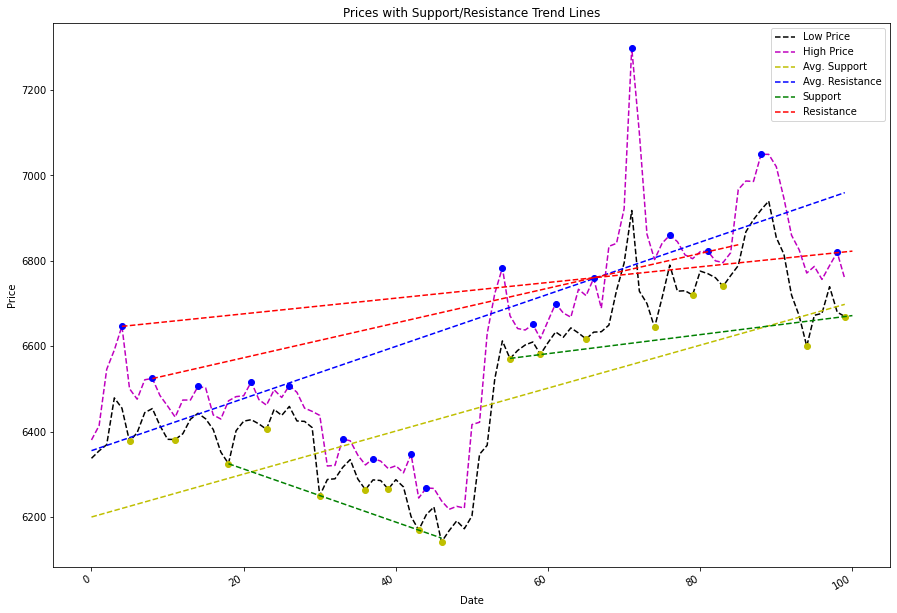

In [48]:
# from trend_line import *
fig = plot_support_resistance((btc_1h['low'].tail(100).values, btc_1h['high'].tail(100).values), x_in=15, y_in=10)

# plt.show()

In [138]:

# mintrend - sorted list containing (points, result) for local minima trend lines
    # points - list of indexes to points in trend line
    # result - (slope, intercept, SSR, slopeErr, interceptErr, areaAvg)
        # slope - slope of best fit trend line
        # intercept - y-intercept of best fit trend line
        # SSR - sum of squares due to regression
        # slopeErr - standard error of slope
        # interceptErr - standard error of intercept
        # areaAvg - Reimann sum area of difference between best fit trend line
        #   and actual data points averaged per time unit


In [169]:
from bokeh.plotting import figure, output_notebook, show
def plot_trend_candlesticks(input_df, num_best=10, line_len_factor=3):
    output_notebook()
    
    df = input_df.copy().reset_index()

    inc = df.close > df.open
    dec = df.open > df.close
    w = 1*60*60*1000*0.6 # 1 h in ms * 0.6 smaller

    p = figure(x_axis_type="datetime", plot_width=1000)
    p.xaxis.major_label_orientation = 3.1415/4
    p.grid.grid_line_alpha=0.3

    p.segment(df.timestamp, df.high, df.timestamp, df.low, color="black")
    p.vbar(df.timestamp[inc], w, df.open[inc], df.close[inc], fill_color="#D5E1DD", line_color="black")
    p.vbar(df.timestamp[dec], w, df.open[dec], df.close[dec], fill_color="#F2583E", line_color="black")
    
    (minima_idxs, p_min, min_trend, min_windows), (maxima_idxs, p_max, max_trend, max_windows) = calc_support_resistance(
        (df['low'].values, df['high'].values))
    num_trends = len(min_trend)
    
    for i, trend_line in enumerate(min_trend[:num_best]):
        slope = trend_line[1][0]
        intercept = trend_line[1][1]
        df['min_trend_{}'.format(i)] = None
        start_idx = trend_line[0][0]
        end_idx = start_idx + (trend_line[0][-1:][0] - start_idx) * line_len_factor
        df['min_trend_{}'.format(i)].iloc[start_idx:end_idx] = [slope * x + intercept for x in df.index[start_idx:end_idx]]
        p.line(df['timestamp'], df['min_trend_{}'.format(i)])
    

    show(p)  


In [170]:
plot_trend_candlesticks(btc_1h.tail(2000), num_best=30, line_len_factor=5)


Loading BokehJS ...